In [87]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [99]:
# Standard library imports
import json
import logging
from datetime import datetime
from pathlib import Path

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sklearn.metrics as metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader, Subset
from torch_geometric.data import DataLoader as PyGDataLoader
from torchvision.transforms import transforms
from tqdm import tqdm

# Local application/library specific imports
from src.data.dataset import MultiviewImgDataset, IFCNetPly, IFCNetNumpy, GNNArchitecturalDataset
from src.models.models import ArcGNN
from src.models.Trainer import Trainer


In [100]:

log_dir = Path(f"./logs/ArcGNN")
log_dir.mkdir(exist_ok=True, parents=True)
data_root_gnn = '/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/data/processed/ArcGNN/RevitBuildings'

category_mapping = { # to sample matching IFCNetCore classes and ArcGNN categories
"Walls": "IfcWall",
"Furniture": "IfcFurniture",
"Doors": "IfcDoor",
"Windows": "IfcDoor", #not in IFC dataset
"Floors": "IfcWall", #not in IFC dataset
"Plumbing Fixtures": "IfcSanitaryTerminal",
"Structural Columns": "IfcBeam",
"Railings": "IfcRailing",
"Structural Framing": "IfcBeam", #not in IFC dataset
"Stairs": "IfcStair"
}    

In [101]:

# Configuration parameters
config = {
    "batch_size": 1,
    "learning_rate": 0.01,
    "weight_decay": 5e-4,
    "epochs": 30,
    # Add other necessary configuration parameters here
}

model_dir = Path('/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/models/')

num_classes = len(category_mapping)
num_node_features = 81  # Assuming each node has 81 features as defined earlier
class_names = list(category_mapping.keys())


In [102]:

train_dataset = GNNArchitecturalDataset(data_root_gnn, class_names, partition="train")
val_dataset = GNNArchitecturalDataset(data_root_gnn, class_names, partition="train")
test_dataset = GNNArchitecturalDataset(data_root_gnn, class_names, partition="test")

np.random.seed(42)
perm = np.random.permutation(range(len(train_dataset)))
train_len = int(0.8 * len(train_dataset))
train_dataset = Subset(train_dataset, perm[:train_len])
val_dataset = Subset(val_dataset, perm[train_len:])

train_loader = PyGDataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_loader = PyGDataLoader(val_dataset, batch_size=config["batch_size"])
test_loader = PyGDataLoader(test_dataset, batch_size=config["batch_size"])

Processing...


There are 42874 files to use in /Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/data/processed/ArcGNN/RevitBuildings/processed_subgraphs


Done!
Processing...


There are 42874 files to use in /Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/data/processed/ArcGNN/RevitBuildings/processed_subgraphs


Done!
Processing...


There are 42874 files to use in /Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/data/processed/ArcGNN/RevitBuildings/processed_subgraphs


Done!
/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/ifcnet-env/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [103]:
model = ArcGNN(num_node_features=num_node_features, num_classes=num_classes)

model_state, _ = torch.load('/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/models/ArcGNN_pretrained/ArcGNNWeights+Optimizer29')
model.load_state_dict(model_state)

<All keys matched successfully>

In [104]:
device = 'cpu' #torch.device("cuda")
model.to(device)

ArcGNN(
  (conv1): GCNConv(81, 128)
  (conv2): GCNConv(128, 10)
)

In [105]:
def calc_metrics(probabilities, labels):
    predictions = np.argmax(probabilities, axis=1)
    print(predictions)

    acc = metrics.accuracy_score(labels, predictions)
    balanced_acc = metrics.balanced_accuracy_score(labels, predictions)
    precision = metrics.precision_score(labels, predictions, average="weighted")
    recall = metrics.recall_score(labels, predictions, average="weighted")
    f1 = metrics.f1_score(labels, predictions, average="weighted")

    return {
        f"accuracy_score": acc,
        f"balanced_accuracy_score": balanced_acc,
        f"precision_score": precision,
        f"recall_score": recall,
        f"f1_score": f1
    }

def plot_confusion_matrix(confusion_matrix, display_labels, fname=None):
    labels = list(display_labels)
    df = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    plt.figure(figsize=(7, 5))
    sn.heatmap(df, cmap="Blues", annot=True, fmt="d", cbar=False)
    plt.ylabel("Actual class")
    plt.xlabel("Predicted class")
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight")

def eval(model, loader, device, class_names, fname=None):
    model.eval()
    all_probs = []
    all_labels = []
    idx = 0

    with torch.no_grad():
        for batch in tqdm(loader):
            idx += 1
            x, edge_index, labels = batch.x.to(device), batch.edge_index.to(device), batch.y.to(device)
            labels -=1
            outputs = model(x, edge_index.t(), batch.batch.to(device))

            probs = F.softmax(outputs, dim=1)
            
            all_probs.append(probs.cpu().detach().numpy())
            all_labels.append(labels.cpu().numpy())
            
            if idx == 1000:
                break

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    result = calc_metrics(all_probs, all_labels)
    predictions = np.argmax(all_probs, axis=1)
    confusion_matrix = metrics.confusion_matrix(all_labels, predictions)
    plot_confusion_matrix(confusion_matrix, class_names, fname=fname)
    return all_labels, all_probs

  3%|▋                       | 999/34299 [00:14<07:47, 71.21it/s]
/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/ifcnet-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[8 8 8 8 8 8 8 8 8 8 2 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 2 8 8 9
 8 9 8 9 8 8 2 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8 8 8 8 9 8 2 8 8 2 8 8 8 2 8 8
 8 8 8 8 8 8 8 8 8 9 8 8 8 9 8 8 8 8 8 8 8 8 8 8 8 8 8 2 8 8 8 8 2 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 8 8 8 9 8 2 8 8 9 8 8 2 8 8 8 8 8 9 8 8
 9 2 8 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 2 8 8 8
 2 8 9 8 8 8 6 8 8 8 8 8 8 8 8 8 6 8 9 8 9 8 8 2 8 2 8 8 8 8 8 9 8 8 8 8 8
 8 8 8 8 8 8 8 8 9 8 8 8 8 8 8 8 2 8 8 8 8 8 2 8 8 8 8 8 2 9 2 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 2 8 8 8 8 8 9 8 8 6 8 8 9 8 8 8 8 8 8 8 8 8 8 1 8 8
 8 2 8 9 8 8 2 2 8 8 8 2 8 8 2 9 8 8 8 8 9 8 8 8 2 6 8 8 8 8 8 8 8 2 8 8 8
 2 8 8 2 8 8 2 8 8 2 8 8 8 8 8 9 8 9 2 8 8 8 8 8 8 8 8 8 8 8 8 8 2 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 2 8 8 8 8 8 8 9 8 8 8 2 8 8 2 8 8 8 8
 8 8 8 8 1 8 2 8 8 8 8 9 8 8 2 8 8 8 8 8 8 8 8 9 8 2 8 9 8 8 8 8 8 9 8 9 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 2 9 8 8 8 8 8 8 8 8 9 8 2 8 8 8 2 8 2 8
 8 8 9 2 8 8 8 2 2 8 8 2 

(array([2, 3, 9, 0, 0, 8, 8, 8, 8, 9, 2, 1, 0, 8, 0, 8, 9, 8, 3, 8, 8, 2,
        2, 8, 8, 0, 0, 1, 8, 8, 8, 1, 8, 2, 0, 8, 3, 8, 9, 3, 8, 1, 8, 2,
        8, 4, 8, 8, 0, 8, 9, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 1, 0, 8, 2, 3,
        8, 2, 4, 0, 8, 2, 8, 8, 1, 8, 9, 5, 8, 0, 8, 8, 8, 2, 8, 2, 8, 0,
        8, 8, 8, 8, 8, 3, 8, 8, 1, 0, 8, 8, 8, 2, 8, 8, 8, 8, 2, 8, 8, 8,
        8, 0, 8, 8, 8, 8, 8, 8, 8, 2, 0, 8, 8, 8, 8, 6, 8, 9, 8, 8, 8, 9,
        0, 2, 8, 8, 9, 8, 0, 2, 1, 8, 8, 8, 3, 9, 3, 8, 8, 2, 8, 8, 8, 8,
        8, 8, 8, 9, 8, 8, 0, 2, 8, 8, 8, 8, 8, 0, 8, 8, 8, 8, 3, 0, 9, 8,
        1, 1, 1, 8, 8, 2, 0, 8, 2, 2, 8, 9, 0, 1, 8, 6, 8, 8, 8, 4, 8, 1,
        8, 8, 8, 6, 8, 0, 8, 0, 8, 1, 2, 8, 3, 8, 0, 8, 8, 4, 0, 0, 0, 0,
        8, 0, 8, 0, 8, 9, 8, 8, 8, 0, 9, 8, 8, 8, 8, 6, 8, 8, 2, 8, 8, 2,
        3, 8, 2, 8, 0, 1, 8, 8, 2, 9, 2, 8, 1, 8, 8, 8, 0, 0, 8, 8, 1, 8,
        8, 8, 8, 8, 1, 8, 2, 8, 0, 8, 8, 0, 8, 8, 8, 4, 8, 2, 8, 8, 8, 8,
        8, 8, 2, 8, 9, 8, 8, 1, 8, 8, 

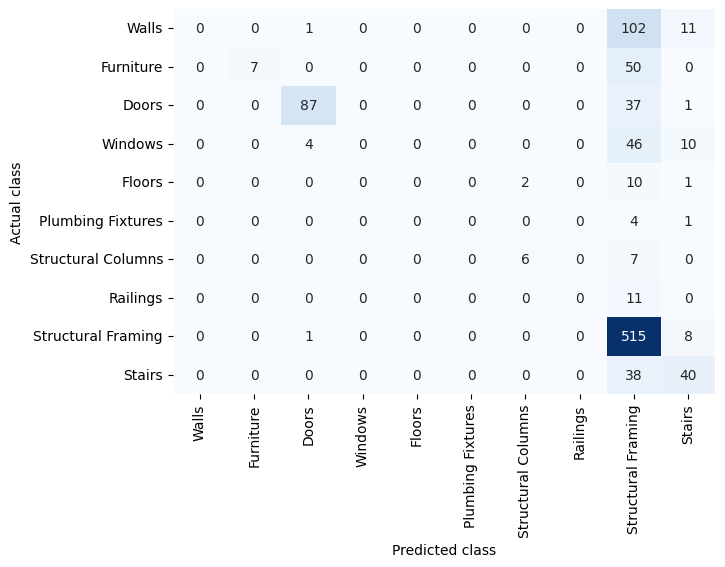

In [106]:
eval(model, train_loader, device, class_names)

 12%|██▉                      | 999/8575 [00:14<01:52, 67.38it/s]
/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/ifcnet-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[8 8 8 9 8 8 9 9 8 9 8 8 6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 1 8 8 8 8 8 8 8 8 8 8 2 8 8 8 8 8 8 8 8 2 8 8 8 8 8 8 2 8 8 8 8 8 8
 8 8 8 9 8 8 8 8 8 8 8 8 8 2 8 8 8 8 8 8 8 8 8 9 2 8 6 8 8 8 8 8 8 8 8 8 2
 8 8 2 8 8 8 8 8 2 8 1 8 8 8 8 8 8 2 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8 8 2 8 8
 9 8 8 2 2 8 8 8 8 8 8 8 8 2 8 8 8 8 8 1 1 8 9 9 8 9 8 8 9 8 8 8 8 8 8 8 1
 8 2 8 8 8 8 8 8 2 8 2 8 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 2 8 8 8 8 8 8 8 8 8 8 8 8 8 9 2 8 2 8 8 9 8 8 8 9 8 8 8
 8 8 8 8 2 8 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8 8 8 8 9 8 8 8 2 8 8 8 8 2 8 8 8
 8 8 8 8 9 8 2 8 8 8 8 8 8 8 8 8 8 2 8 8 8 8 9 8 8 8 8 8 8 8 8 2 8 2 9 8 8
 8 8 2 8 8 8 8 9 9 8 8 8 8 8 8 8 9 8 8 2 8 9 9 8 8 8 9 8 8 8 9 8 8 8 8 8 8
 8 8 8 2 2 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 2 8 8 8 8 8 8 9 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 9 8 8 9 8 2 1 8 8 9 8 8 8 9 8 8 8 8 9 8 2 8 8 8 8 2 8 8
 8 8 8 8 8 8 8 8 8 8 9 8 8 2 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 8 8 2
 2 9 8 8 8 8 8 8 2 8 9 8 

(array([8, 8, 8, 9, 8, 3, 9, 0, 3, 4, 1, 8, 6, 3, 1, 0, 2, 8, 8, 8, 7, 8,
        8, 6, 8, 3, 3, 8, 8, 8, 8, 8, 9, 1, 8, 8, 0, 0, 8, 0, 1, 8, 6, 2,
        0, 8, 8, 9, 8, 8, 8, 2, 2, 2, 8, 0, 8, 8, 8, 8, 2, 8, 8, 2, 8, 8,
        8, 2, 3, 8, 0, 8, 3, 0, 8, 0, 8, 8, 8, 9, 8, 8, 8, 8, 0, 8, 6, 3,
        8, 8, 8, 0, 0, 8, 8, 1, 8, 3, 2, 0, 6, 2, 7, 0, 7, 2, 8, 8, 8, 0,
        2, 0, 8, 2, 8, 8, 2, 6, 8, 2, 8, 1, 8, 8, 8, 8, 8, 8, 2, 9, 8, 8,
        3, 0, 1, 9, 8, 8, 0, 0, 8, 8, 8, 8, 8, 4, 8, 8, 3, 9, 3, 2, 2, 1,
        8, 3, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 1, 1, 0, 3, 8, 8, 9, 8, 0,
        9, 1, 8, 2, 4, 9, 2, 6, 1, 3, 2, 3, 8, 8, 8, 3, 0, 2, 2, 2, 8, 3,
        9, 8, 8, 0, 8, 3, 2, 8, 8, 9, 8, 8, 8, 6, 8, 2, 0, 8, 1, 8, 8, 8,
        8, 0, 8, 8, 8, 0, 0, 8, 9, 8, 8, 2, 8, 1, 0, 8, 8, 8, 2, 8, 8, 3,
        0, 8, 8, 9, 2, 8, 2, 0, 1, 9, 2, 8, 9, 0, 8, 8, 8, 8, 8, 8, 8, 2,
        9, 8, 8, 0, 8, 8, 8, 3, 0, 8, 2, 3, 0, 8, 8, 8, 8, 8, 8, 9, 3, 8,
        8, 2, 8, 8, 8, 8, 2, 8, 2, 6, 

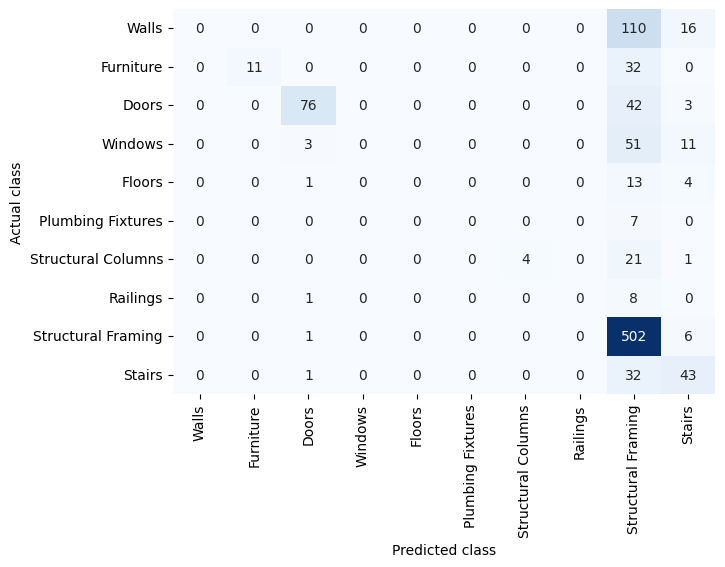

In [107]:
eval(model, val_loader, device, class_names)

In [108]:
test_labels, test_probs = eval(model, test_loader, device,
                               class_names, fname="../reports/figures/mvcnn_confusion.png")

  2%|▌                       | 999/42874 [00:14<10:28, 66.67it/s]
/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/ifcnet-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/ifcnet-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/ifcnet-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_p

[8 8 8 8 8 8 8 8 8 1 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9
 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 8 8 8 9 9 8 9 9 8 8 8 8 9 8 8
 8 9 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8 9 9 9 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8 9 9 9 8 8 8 8 8 9 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8 9 9 9 8 8 8 8 2 8 2 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8 9 9 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 9 8 8 8 8 8 8 8 8 9 9 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8
 9 9 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8 9 9
 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8 9 9 9 8
 8 8 8 2 8 2 8 8 8 8 8 8 

ValueError: Shape of passed values is (7, 7), indices imply (10, 10)

In [98]:
np.savez("ArcGNNProbs.npz", labels=test_labels, probs=test_probs)

NameError: name 'test_labels' is not defined

In [ ]:
test_predictions = np.argmax(test_probs, axis=1)
wrong_predictions = np.where(test_labels != test_predictions)[0]